ToDo:
* Do other cost functions further decrease the loss?

In [11]:
%reset
%env MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt;
%env MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131;

In [2]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import matplotlib.pyplot as plt

import miscellaneous as msc

Model

In [3]:
expert_policy_file = "experts/Hopper-v1.pkl"
envname = "Hopper-v1"
render = False
num_rollouts = 5

In [4]:
policy_fn = load_policy.load_policy(expert_policy_file)

('obs', (1, 11), (1, 11))


SET UP tensorflow    

In [5]:
input = tf.placeholder(tf.float32, shape=(1,11))
label = tf.placeholder(tf.float32, shape=(1,3))
pred = msc.neural_network(input)

cost = tf.losses.absolute_difference(label, pred)
train_step = tf.train.AdamOptimizer(1e-4).minimize(cost)

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

observations = []
actions = []
env = gym.make(envname)
for i in range(num_rollouts):
    observations_rollout, actions_rollout = msc.rollout(env, policy_fn, render)
    observations += observations_rollout
    actions += actions_rollout

[2017-09-17 20:44:22,774] Making new env: Hopper-v1


Learn new policy

In [7]:
predicted_actions = []
for k in range(1):
    for observation, action in zip(observations, actions):
        train_step.run(feed_dict={input: observation, label: action})
        pred_action = sess.run(pred, feed_dict={input: observation})
        predicted_actions.append(pred_action)

In [8]:
predicted_actions_array = np.array(predicted_actions)
actual_actions_array = np.array(actions)
evaluated_cost = np.sum(np.abs(actual_actions_array-predicted_actions_array),axis=2)

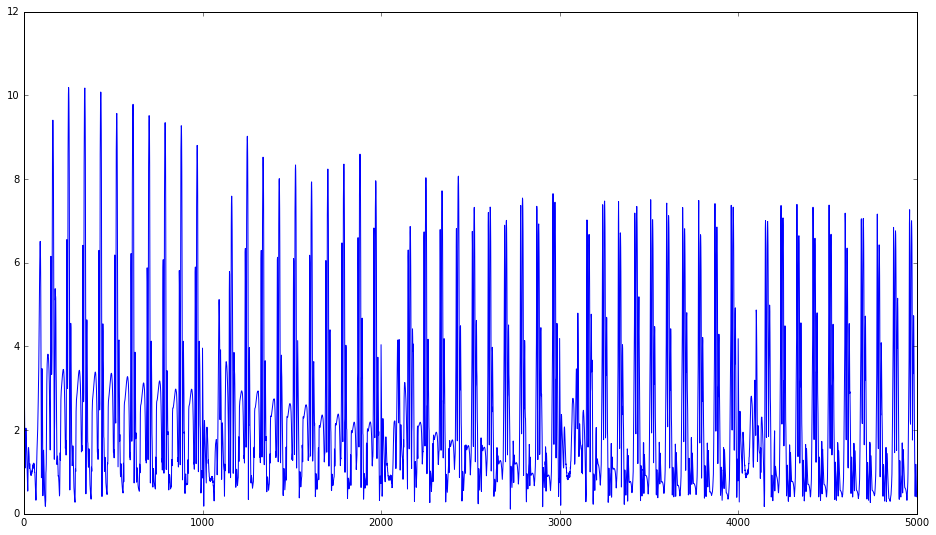

In [9]:
plt.figure(figsize=(16,9))
plt.plot(evaluated_cost)
plt.show()

In [10]:
# Simulate learned policy
obs = env.reset()
done = False
while not done:
    pred_action = sess.run(pred, feed_dict={input: obs.reshape(1,11)})

    obs, r, done, _ = env.step(pred_action)
    env.render()